# SSD Object Detection — Oxford-IIIT Pet


- 데이터셋: Oxford-IIIT Pet Dataset
- 목적: 객체 탐지(Object Detection) 실습
- 모델: **SSD300 (VGG16 Backbone)**
- 데이터 EDA는 실제 프로젝트 결과와 방향성이 달라, 별도 파일로 아카이빙


## 0. 라이브러리 Import 및 디바이스 설정

In [70]:
# ============================================================
# 1) 기본 / 시스템 유틸
# ============================================================
import os
import sys
import math
import random
from glob import glob
from pathlib import Path
import xml.etree.ElementTree as ET    # VOC XML 파싱용

# ============================================================
# 2) 수치 / 데이터 처리
# ============================================================
import numpy as np
import pandas as pd

# ============================================================
# 3) 이미지 처리
# ============================================================
import cv2
from PIL import Image

# ============================================================
# 4) PyTorch & TorchVision
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import v2
import torchvision.transforms.functional as TF

# Object Detection 모델 / 연산
from torchvision.models.detection import ssd300_vgg16
from torchvision.models import VGG16_Weights
from torchvision.ops import box_iou, nms
from torchvision.utils import draw_bounding_boxes

# ============================================================
# 5) 시각화
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# 선택적으로 사용 (Notebook일 경우에만)
from tqdm.auto import tqdm

# ============================================================
# 환경 정보 출력
# ============================================================
print(f"PyTorch: {torch.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"OpenCV: {cv2.__version__}")

PyTorch: 2.9.0+cu126
NumPy: 2.0.2
Pandas: 2.2.2
OpenCV: 4.12.0


In [24]:
def get_device():
    """
    사용 가능한 연산 장치를 자동으로 탐지하여 반환하는 함수.

    동작 우선순위:
    1. CUDA GPU가 존재하면 'cuda' 장치를 반환
    2. (Mac 전용) Apple Silicon MPS 가속기가 가능하면 'mps' 장치를 반환
    3. 위 두 옵션이 모두 없을 경우 CPU 장치를 반환

    Returns:
        torch.device: 선택된 연산 장치 (cuda / mps / cpu)
    """
    # 1) CUDA (Colab or PC)
    # (코랩 설정 필요: 메뉴 - 런타임 - 런타임 유형 변경 - 하드웨어 가속기)
    if torch.cuda.is_available():
        print("CUDA GPU detected.")
        return torch.device("cuda")

    # 2) Apple Silicon (Local Mac)
    if torch.backends.mps.is_available():
        print("Apple MPS GPU detected.")
        return torch.device("mps")

    # 3) CPU fallback
    print("No GPU detected. Using CPU.")
    return torch.device("cpu")


device = get_device()
print(f"Using device: {device}")

CUDA GPU detected.
Using device: cuda


In [25]:
import logging

def init_logger():
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)

    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s [%(levelname)s] (%(filename)s:%(lineno)d) - %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
        force=True,                 # ← Jupyter에서 강제 재설정
    )
    return logging.getLogger("pneumonia")

logger = init_logger()
logger.info("Logger initialized")

2025-12-01 05:09:16 [INFO] (ipython-input-2436937078.py:16) - Logger initialized


# 데이터 불러오기

In [26]:
# ============================================================
# 경로 & 메타 파일 로딩
# ============================================================
import kagglehub

dataset_root = Path(
    kagglehub.dataset_download(
        "zippyz/cats-and-dogs-breeds-classification-oxford-dataset"
    )
)
print("Dataset root:", dataset_root)

image_dir = dataset_root / "images" / "images"
xml_dir   = dataset_root / "annotations" / "annotations" / "xmls"
ann_dir   = dataset_root / "annotations" / "annotations"

trainval_file = ann_dir / "trainval.txt"
test_file     = ann_dir / "test.txt"
train_file    = ann_dir / "train.txt"   # 있으면 사용
val_file      = ann_dir / "val.txt"     # 있으면 사용

print("Image dir :", image_dir)
print("XML dir   :", xml_dir)
print("ann dir   :", ann_dir)

def load_ann_txt(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, sep=r"\s+", header=None)
    df.columns = ["Image", "ClassID", "Species", "BreedID"]
    return df

df_trainval = load_ann_txt(trainval_file)
df_test     = load_ann_txt(test_file)

df_train = load_ann_txt(train_file) if train_file.exists() else None
df_val   = load_ann_txt(val_file)   if val_file.exists()   else None

print(f"\nTrainVal rows : {len(df_trainval)}")
print(f"Test rows     : {len(df_test)}")
if df_train is not None and df_val is not None:
    print(f"Train rows    : {len(df_train)}")
    print(f"Val rows      : {len(df_val)}")


Using Colab cache for faster access to the 'cats-and-dogs-breeds-classification-oxford-dataset' dataset.
Dataset root: /kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset
Image dir : /kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset/images/images
XML dir   : /kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset/annotations/annotations/xmls
ann dir   : /kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset/annotations/annotations

TrainVal rows : 3680
Test rows     : 3669


In [27]:
# ============================================================
# XML 파싱 함수 (단일 버전만 사용)
# ============================================================
def parse_annotation_xml(xml_path: Path):
    """
    하나의 XML(annotation) 파일을 파싱해서
    이미지 크기 + bbox 리스트를 반환.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename_tag = root.find("filename")
    filename = filename_tag.text if filename_tag is not None else xml_path.stem

    size_tag = root.find("size")
    width = int(size_tag.find("width").text)
    height = int(size_tag.find("height").text)

    boxes = []
    for obj in root.findall("object"):
        name = obj.find("name").text
        bnd  = obj.find("bndbox")
        xmin = int(bnd.find("xmin").text)
        ymin = int(bnd.find("ymin").text)
        xmax = int(bnd.find("xmax").text)
        ymax = int(bnd.find("ymax").text)

        boxes.append(
            {
                "class_name": name,
                "xmin": xmin,
                "ymin": ymin,
                "xmax": xmax,
                "ymax": ymax,
            }
        )

    return {
        "filename": filename,
        "width": width,
        "height": height,
        "boxes": boxes,
    }


In [28]:
# ============================================================
# img_id → annotation / species 매핑
# ============================================================
# trainval 전체에 대해, xml 있는 것만 파싱
ann_by_id = {}
missing_xml = []

for img_id in df_trainval["Image"]:
    xml_path = xml_dir / f"{img_id}.xml"
    if not xml_path.exists():
        missing_xml.append(img_id)
        continue
    ann_by_id[img_id] = parse_annotation_xml(xml_path)

print(f"\nTrainVal 총 ID 수     : {len(df_trainval)}")
print(f"XML 있는 ID 수        : {len(ann_by_id)}")
print(f"XML 없는 ID 수        : {len(missing_xml)}")

# img_id → Species (1=cat, 2=dog), 단 xml 있는 것만
df_trainval_valid = df_trainval[df_trainval["Image"].isin(ann_by_id.keys())].copy()
df_trainval_valid = df_trainval_valid.set_index("Image")
id_to_species = df_trainval_valid["Species"].to_dict()

print("샘플 ID:", next(iter(id_to_species.keys())))
print("샘플 Species:", id_to_species[next(iter(id_to_species.keys()))])



TrainVal 총 ID 수     : 3680
XML 있는 ID 수        : 3671
XML 없는 ID 수        : 9
샘플 ID: Abyssinian_100
샘플 Species: 1


In [29]:
# ============================================================
# Train / Val / Test ID 구성
#    - train.txt / val.txt 있으면 그걸 사용
#    - 없으면 trainval.txt에서 8:2 랜덤 split
# ============================================================
if df_train is not None and df_val is not None:
    # 공식 split 사용
    raw_train_ids = df_train["Image"].tolist()
    raw_val_ids   = df_val["Image"].tolist()
else:
    # 없으면 trainval을 8:2로 직접 나눔 (fallback)
    all_ids = df_trainval["Image"].tolist()
    random.seed(42)
    random.shuffle(all_ids)
    n_val = int(len(all_ids) * 0.2)
    raw_val_ids   = all_ids[:n_val]
    raw_train_ids = all_ids[n_val:]

test_ids = df_test["Image"].tolist()

def filter_ids(ids, ann_by_id, id_to_species):
    """xml 있고 species 정보 있는 id만 남김."""
    return [
        i for i in ids
        if (i in ann_by_id) and (i in id_to_species)
    ]

train_ids = filter_ids(raw_train_ids, ann_by_id, id_to_species)
val_ids   = filter_ids(raw_val_ids,   ann_by_id, id_to_species)
test_ids  = filter_ids(test_ids,      ann_by_id, id_to_species)  # 필요하면 사용

print(f"\nTrain IDs (after filter): {len(train_ids)}")
print(f"Val   IDs (after filter): {len(val_ids)}")
print(f"Test  IDs (after filter): {len(test_ids)}")



Train IDs (after filter): 2938
Val   IDs (after filter): 733
Test  IDs (after filter): 0


In [30]:
# ============================================================
# Dataset 정의 (최소 버전, ToTensor만)
# ============================================================
class PetFaceDataset(Dataset):
    """
    Oxford Pet face detection용 최소 Dataset.
    - transforms는 나중에 SSD용 augmentation 넣을 때 사용 (지금은 None로 두고 ToTensor만).
    """

    def __init__(self, image_dir: Path, ann_by_id: dict,
                 id_to_species: dict, image_ids, transforms=None):
        self.image_dir = Path(image_dir)
        self.ann_by_id = ann_by_id
        self.id_to_species = id_to_species
        self.image_ids = [
            i for i in sorted(image_ids)
            if (i in ann_by_id and i in id_to_species)
        ]
        self.transforms = transforms
        self.to_tensor = T.ToTensor()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]

        # 1) 이미지 로드
        img_path = self.image_dir / f"{img_id}.jpg"
        img = Image.open(img_path).convert("RGB")

        # 2) 어노테이션에서 bbox / label 생성
        ann = self.ann_by_id[img_id]
        boxes_raw = ann["boxes"]

        boxes = []
        for b in boxes_raw:
            boxes.append([b["xmin"], b["ymin"], b["xmax"], b["ymax"]])
        boxes = torch.tensor(boxes, dtype=torch.float32)  # [N, 4]

        species = int(self.id_to_species[img_id])  # 1=cat, 2=dog
        labels = torch.full((boxes.shape[0],), species, dtype=torch.int64)

        # transforms가 bbox까지 건드는 경우를 대비해서 분기
        if self.transforms is not None:
            img, boxes, labels = self.transforms(img, boxes, labels)
        else:
            img = self.to_tensor(img)  # [3, H, W]

        # area / iscrowd / image_id
        areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        image_id = torch.tensor([idx])

        target = {
            "boxes":   boxes,
            "labels":  labels,
            "area":    areas,
            "iscrowd": iscrowd,
            "image_id": image_id,
        }
        return img, target

# Train / Val Dataset 생성
train_dataset = PetFaceDataset(
    image_dir=image_dir,
    ann_by_id=ann_by_id,
    id_to_species=id_to_species,
    image_ids=train_ids,
    transforms=None,  # ✅ 지금 baseline은 ToTensor만 사용
)

val_dataset = PetFaceDataset(
    image_dir=image_dir,
    ann_by_id=ann_by_id,
    id_to_species=id_to_species,
    image_ids=val_ids,
    transforms=None,
)

print("\nTrain dataset 길이:", len(train_dataset))
print("Val dataset 길이  :", len(val_dataset))



Train dataset 길이: 2938
Val dataset 길이  : 733


In [31]:
# ============================================================
# DataLoader + collate_fn
# ============================================================
def detection_collate_fn(batch):
    """
    Object Detection용 DataLoader에서 사용할 collate_fn.

    batch : list of (image, target)
        - image : Tensor[3, H, W]
        - target: dict("boxes", "labels", ...)

    Returns
    -------
    images : list[Tensor]
    targets : list[dict]
    """
    images, targets = list(zip(*batch))
    return list(images), list(targets)

BATCH_SIZE = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=detection_collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=detection_collate_fn,
)

# 한 배치 sanity check
images, targets = next(iter(train_loader))
print("\n[Sanity Check] 배치 이미지 개수:", len(images))
print("첫 번째 이미지 shape:", images[0].shape)
print("첫 번째 타깃 keys:", targets[0].keys())
print("첫 번째 타깃 boxes shape:", targets[0]["boxes"].shape)
print("첫 번째 타깃 labels:", targets[0]["labels"])



[Sanity Check] 배치 이미지 개수: 8
첫 번째 이미지 shape: torch.Size([3, 500, 330])
첫 번째 타깃 keys: dict_keys(['boxes', 'labels', 'area', 'iscrowd', 'image_id'])
첫 번째 타깃 boxes shape: torch.Size([1, 4])
첫 번째 타깃 labels: tensor([1])


In [39]:
# ============================================================
# Dataset 시각화 함수
# ============================================================
def viz_dataset_sample(dataset, idx):
    img, target = dataset[idx]

    img_np = img.permute(1, 2, 0).numpy()
    boxes  = target["boxes"].numpy()
    labels = target["labels"].numpy()

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img_np)

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box

        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor="red",
            linewidth=2,
        )
        ax.add_patch(rect)

        ax.text(
            xmin,
            ymin - 5,
            f"Species={int(label)}",  # 1=cat, 2=dog
            color="yellow",
            fontsize=8,
            bbox=dict(facecolor="black", alpha=0.5, edgecolor="none"),
        )

    ax.axis("off")
    plt.show()


In [ ]:
# 확인 필요할 때만 수동 호출 (class : 0:background, 1:cat, 2:dog)
# for _ in range(3):
#     idx = random.randint(0, len(train_dataset) - 1)
#     print("샘플 인덱스:", idx)
#     viz_dataset_sample(train_dataset, idx)

# 모델 및 학습 함수 정의

In [38]:
# ============================================================
# SSD300 + VGG16 모델 정의
#    - 0: background, 1: cat, 2: dog
# ============================================================
NUM_CLASSES = 3

model_ssd = ssd300_vgg16(
    weights_backbone=VGG16_Weights.IMAGENET1K_V1,  # backbone만 ImageNet pretrain
    num_classes=NUM_CLASSES,                       # detection head는 새로 초기화
).to(device)

model_ssd.train()

# (선택) 한 배치 loss sanity check – 필요할 때만 한번 실행
# images, targets = next(iter(train_loader))
# images  = [img.to(device) for img in images]
# targets = [{k: v.to(device) for k, v in tgt.items()} for tgt in targets]
# with torch.autograd.set_grad_enabled(True):
#     loss_dict = model_ssd(images, targets)
# print("SSD loss keys:", loss_dict.keys())
# for k, v in loss_dict.items():
#     print(f"{k}: {float(v):.4f}")
# print("총 loss:", float(sum(loss_dict.values())))


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [40]:
# ============================================================
# 학습 하이퍼파라미터 & Optimizer / LR Scheduler
# ============================================================
num_epochs   = 10
lr           = 0.001
weight_decay = 5e-4

optimizer_ssd = torch.optim.SGD(
    model_ssd.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=weight_decay,
)

lr_scheduler_ssd = torch.optim.lr_scheduler.StepLR(
    optimizer_ssd,
    step_size=5,
    gamma=0.1,
)


In [41]:
# ============================================================
# Epoch 학습 함수 (Loss: cls + bbox, + non-finite 체크, grad clipping)
# ============================================================
def train_one_epoch_ssd(model, optimizer, data_loader, device, epoch: int):
    """
    SSD300 + VGG16 한 epoch 학습 함수.
    - loss = classification + bbox_regression
    - non-finite loss 방어
    - gradient clipping 포함
    """
    model.train()
    loss_meter = defaultdict(float)
    num_batches = 0

    pbar = tqdm(data_loader, desc=f"[SSD][Epoch {epoch}]")

    for images, targets in pbar:
        # 1) 디바이스로 이동
        images  = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in tgt.items()} for tgt in targets]

        # 2) forward → loss dict
        loss_dict = model(images, targets)  # {"classification": ..., "bbox_regression": ...}
        loss_cls  = loss_dict["classification"]
        loss_bbox = loss_dict["bbox_regression"]
        loss      = loss_cls + loss_bbox

        # 2.5) non-finite 방어
        if not torch.isfinite(loss):
            print(f"❌ Non-finite loss at epoch {epoch}, batch {num_batches}")
            print("   loss:", loss.item())
            print("   cls :", loss_cls.item())
            print("   bbox:", loss_bbox.item())
            break

        # 3) backward
        optimizer.zero_grad()
        loss.backward()

        # 3.5) gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()

        # 4) 로그 누적
        num_batches += 1
        loss_meter["total"]          += loss.item()
        loss_meter["classification"] += loss_cls.item()
        loss_meter["bbox_regression"] += loss_bbox.item()

        pbar.set_postfix({
            "total": f"{loss_meter['total']/num_batches:.3f}",
            "cls":   f"{loss_meter['classification']/num_batches:.3f}",
            "bbox":  f"{loss_meter['bbox_regression']/num_batches:.3f}",
        })

    # 5) batch 평균
    for k in loss_meter.keys():
        loss_meter[k] /= max(num_batches, 1)

    return loss_meter


# 학습

In [42]:
# ============================================================
# 전체 학습 루프 + Loss History 저장
# ============================================================
history_ssd = []

for epoch in range(1, num_epochs + 1):
    epoch_loss = train_one_epoch_ssd(
        model=model_ssd,
        optimizer=optimizer_ssd,
        data_loader=train_loader,
        device=device,
        epoch=epoch,
    )
    history_ssd.append(epoch_loss)

    print(
        f"\n[SSD][Epoch {epoch}] "
        f"total={epoch_loss['total']:.4f}, "
        f"cls={epoch_loss['classification']:.4f}, "
        f"bbox={epoch_loss['bbox_regression']:.4f}"
    )

    lr_scheduler_ssd.step()

    # 체크포인트 저장
    ckpt_path = f"ssd_vgg16_epoch{epoch:02d}.pth"
    torch.save(model_ssd.state_dict(), ckpt_path)
    print(f"Checkpoint saved: {ckpt_path}")


[SSD][Epoch 1]:   0%|          | 0/368 [00:00<?, ?it/s]


[SSD][Epoch 1] total=9.1805, cls=6.3530, bbox=2.8275
Checkpoint saved: ssd_vgg16_epoch01.pth


[SSD][Epoch 2]:   0%|          | 0/368 [00:00<?, ?it/s]


[SSD][Epoch 2] total=4.8079, cls=3.0146, bbox=1.7933
Checkpoint saved: ssd_vgg16_epoch02.pth


[SSD][Epoch 3]:   0%|          | 0/368 [00:00<?, ?it/s]


[SSD][Epoch 3] total=4.2336, cls=2.7831, bbox=1.4504
Checkpoint saved: ssd_vgg16_epoch03.pth


[SSD][Epoch 4]:   0%|          | 0/368 [00:00<?, ?it/s]


[SSD][Epoch 4] total=3.6530, cls=2.4743, bbox=1.1786
Checkpoint saved: ssd_vgg16_epoch04.pth


[SSD][Epoch 5]:   0%|          | 0/368 [00:00<?, ?it/s]


[SSD][Epoch 5] total=3.1446, cls=2.1219, bbox=1.0226
Checkpoint saved: ssd_vgg16_epoch05.pth


[SSD][Epoch 6]:   0%|          | 0/368 [00:00<?, ?it/s]


[SSD][Epoch 6] total=2.5648, cls=1.7747, bbox=0.7901
Checkpoint saved: ssd_vgg16_epoch06.pth


[SSD][Epoch 7]:   0%|          | 0/368 [00:00<?, ?it/s]


[SSD][Epoch 7] total=2.4649, cls=1.7089, bbox=0.7561
Checkpoint saved: ssd_vgg16_epoch07.pth


[SSD][Epoch 8]:   0%|          | 0/368 [00:00<?, ?it/s]


[SSD][Epoch 8] total=2.4032, cls=1.6666, bbox=0.7366
Checkpoint saved: ssd_vgg16_epoch08.pth


[SSD][Epoch 9]:   0%|          | 0/368 [00:00<?, ?it/s]


[SSD][Epoch 9] total=2.3504, cls=1.6313, bbox=0.7190
Checkpoint saved: ssd_vgg16_epoch09.pth


[SSD][Epoch 10]:   0%|          | 0/368 [00:00<?, ?it/s]


[SSD][Epoch 10] total=2.2966, cls=1.5934, bbox=0.7032
Checkpoint saved: ssd_vgg16_epoch10.pth


In [43]:
# ============================================================
# 학습 곡선 시각화
# ============================================================
df_hist = pd.DataFrame(history_ssd)
df_hist.index = df_hist.index + 1
df_hist = df_hist.reset_index().rename(columns={"index": "epoch"})

fig = px.line(
    df_hist,
    x="epoch",
    y=["total", "classification", "bbox_regression"],
    title="SSD300 Training Loss",
    markers=True,
)
fig.update_layout(
    xaxis_title="Epoch",
    yaxis_title="Loss",
    legend_title="Loss Type",
    template="plotly_white",
)
fig.show()

df_hist  # 필요하면 테이블도 같이 확인



epoch     total  classification  bbox_regression
0      1  9.180499        6.353019         2.827479
1      2  4.807882        3.014628         1.793255
2      3  4.233554        2.783150         1.450405
3      4  3.652973        2.474338         1.178635
4      5  3.144567        2.121922         1.022644
5      6  2.564812        1.774699         0.790113
6      7  2.464919        1.708854         0.756064
7      8  2.403200        1.666616         0.736585
8      9  2.350378        1.631338         0.719041
9     10  2.296643        1.593433         0.703210

In [100]:
# ============================================================
# Detection 결과 시각화 유틸
#     (1) Dataset 기반 – GT vs Pred 같이 보기
#     (2) 단일 이미지 파일 경로 기반
# ============================================================
species_map = {1: "Cat", 2: "Dog"}
to_tensor = T.ToTensor()  # 파일 기반 시각화용

def viz_ssd_prediction(dataset, model, idx, device="cpu", score_thresh=0.5):
    """
    (1) Dataset 기준 시각화: GT 박스(초록) + 예측 박스(빨강)
    """
    model.eval()

    # 1) 데이터셋에서 이미지 & GT 가져오기
    img, target = dataset[idx]
    img_device = img.to(device)

    with torch.no_grad():
        output = model([img_device])[0]  # SSD는 list[dict] 반환

    # 2) CPU로 다시 가져오기
    img_np    = img.permute(1, 2, 0).cpu().numpy()
    gt_boxes  = target["boxes"].cpu().numpy()
    gt_labels = target["labels"].cpu().numpy()

    pred_boxes  = output["boxes"].cpu().numpy()
    pred_scores = output["scores"].cpu().numpy()
    pred_labels = output["labels"].cpu().numpy()

    # score threshold로 필터링
    keep = pred_scores >= score_thresh
    pred_boxes  = pred_boxes[keep]
    pred_scores = pred_scores[keep]
    pred_labels = pred_labels[keep]

    # 3) 그리기
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img_np)

    # GT 박스 (초록)
    for box, label in zip(gt_boxes, gt_labels):
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor="lime",
            linewidth=2,
        )
        ax.add_patch(rect)
        cls_name = species_map.get(int(label), str(int(label)))
        ax.text(
            xmin,
            ymin - 5,
            f"GT: {cls_name}",
            color="white",
            fontsize=8,
            bbox=dict(facecolor="green", alpha=0.5, edgecolor="none"),
        )

    # Pred 박스 (빨강)
    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor="red",
            linewidth=2,
        )
        ax.add_patch(rect)
        cls_name = species_map.get(int(label), str(int(label)))
        ax.text(
            xmin,
            ymax + 10,
            f"Pred: {cls_name} ({score:.2f})",
            color="yellow",
            fontsize=8,
            bbox=dict(facecolor="red", alpha=0.5, edgecolor="none"),
        )

    ax.axis("off")
    plt.title(f"SSD Prediction vs GT (idx={idx}, thr={score_thresh})")
    plt.show()

Train Sample idx: 2021


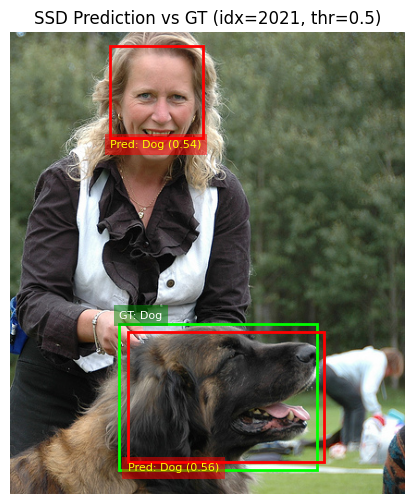

Train Sample idx: 1684


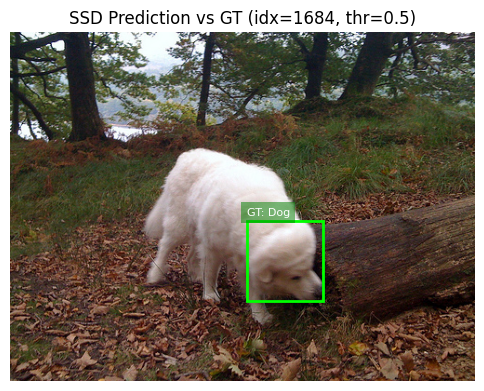

Train Sample idx: 2264


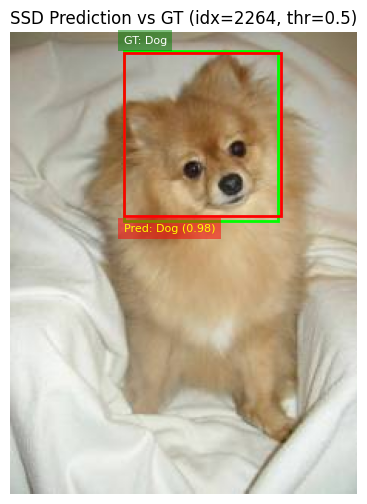

Train Sample idx: 496


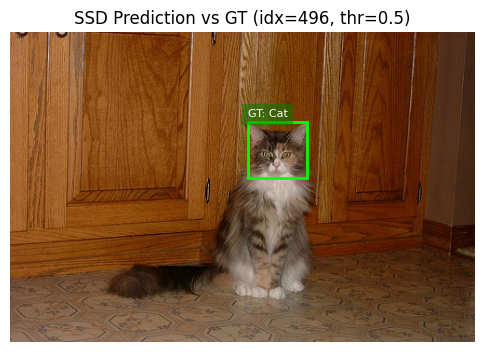

Train Sample idx: 1510


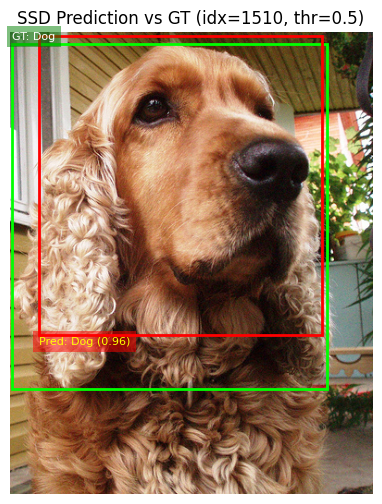

Val Sample idx: 78


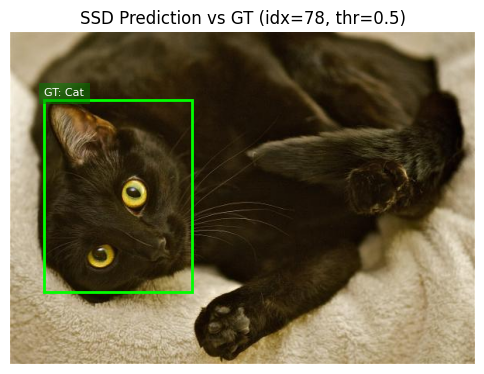

Val Sample idx: 107


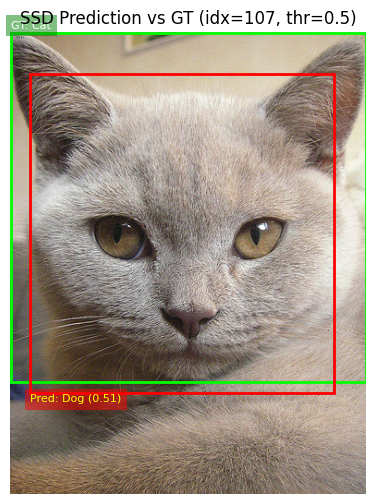

Val Sample idx: 516


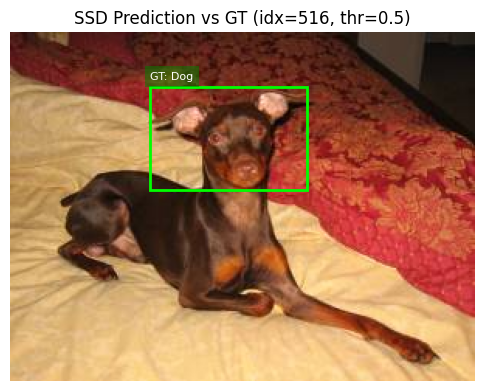

Val Sample idx: 333


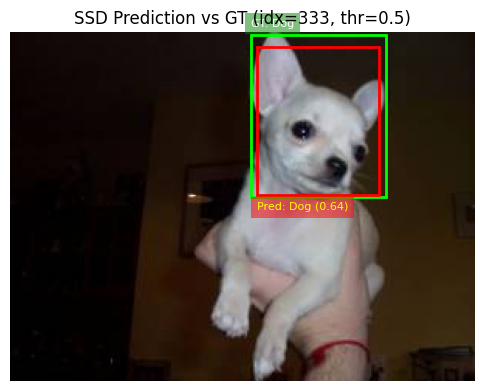

Val Sample idx: 419


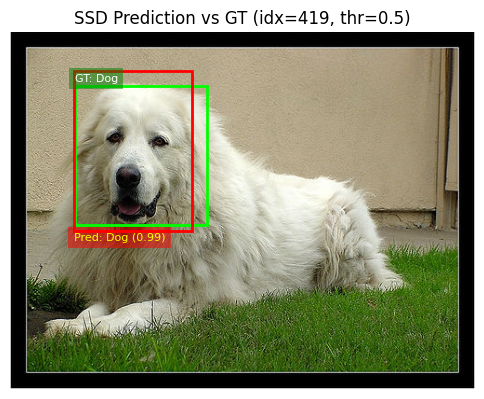

In [99]:
# (선택) 학습 후 Train / Val 샘플 몇 개 확인
for _ in range(5):
    idx = random.randint(0, len(train_dataset) - 1)
    print("Train Sample idx:", idx)
    viz_ssd_prediction(train_dataset, model_ssd, idx, device=device, score_thresh=0.5)

for _ in range(5):
    idx = random.randint(0, len(val_dataset) - 1)
    print("Val Sample idx:", idx)
    viz_ssd_prediction(val_dataset, model_ssd, idx, device=device, score_thresh=0.5)

# 평가

In [56]:
# -------------------------------
# 단일 박스 IoU (xyxy)
# -------------------------------
def box_iou_xyxy(box1, box2):
    """
    box1, box2: [x1, y1, x2, y2]
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_w = max(0.0, x2 - x1)
    inter_h = max(0.0, y2 - y1)
    inter = inter_w * inter_h

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = area1 + area2 - inter
    if union <= 0:
        return 0.0
    return inter / union


In [57]:
# -------------------------------
# 간단한 Precision / Recall / mean IoU
# -------------------------------
def eval_ssd_simple(model, dataset, device, iou_thresh=0.5, score_thresh=0.5):
    """
    - 모델/데이터셋/디바이스만 넣으면:
      Precision, Recall, mean IoU, TP/Det/GT 수를 딕셔너리로 반환
    """
    model.eval()
    num_gt = 0
    num_det = 0
    num_tp = 0
    iou_list = []

    for idx in tqdm(range(len(dataset))):
        img, target = dataset[idx]
        img = img.to(device)

        gt_boxes = target["boxes"].cpu().numpy()
        gt_labels = target["labels"].cpu().numpy()
        num_gt += len(gt_boxes)

        with torch.no_grad():
            out = model([img])[0]

        pred_boxes = out["boxes"].cpu().numpy()
        pred_scores = out["scores"].cpu().numpy()
        pred_labels = out["labels"].cpu().numpy()

        # score threshold 필터링
        keep = pred_scores >= score_thresh
        pred_boxes = pred_boxes[keep]
        pred_labels = pred_labels[keep]
        # pred_scores는 여기선 사용 안 하지만, 필요하면 같이 필터링 가능

        num_det += len(pred_boxes)

        matched_gt = set()

        for pb, pl in zip(pred_boxes, pred_labels):
            best_iou = 0.0
            best_j = -1

            for j, (gb, gl) in enumerate(zip(gt_boxes, gt_labels)):
                if j in matched_gt:
                    continue
                if pl != gl:
                    continue

                iou = box_iou_xyxy(pb, gb)
                if iou > best_iou:
                    best_iou = iou
                    best_j = j

            if best_iou >= iou_thresh and best_j >= 0:
                num_tp += 1
                matched_gt.add(best_j)
                iou_list.append(best_iou)

    precision = num_tp / max(num_det, 1)
    recall = num_tp / max(num_gt, 1)
    mean_iou = float(np.mean(iou_list)) if iou_list else 0.0

    return {
        "precision": precision,
        "recall": recall,
        "mean_iou": mean_iou,
        "num_tp": num_tp,
        "num_det": num_det,
        "num_gt": num_gt,
    }



In [58]:
# -------------------------------
# IoU 행렬 계산 (AP/mAP용)
# -------------------------------
def compute_iou_matrix(pred_boxes, gt_boxes):
    """
    pred_boxes: [N,4]
    gt_boxes  : [M,4]
    return   : [N,M] IoU matrix
    """
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return np.zeros((len(pred_boxes), len(gt_boxes)))

    pred = pred_boxes[:, None, :]  # [N,1,4]
    gt   = gt_boxes[None, :, :]   # [1,M,4]

    x1 = np.maximum(pred[..., 0], gt[..., 0])
    y1 = np.maximum(pred[..., 1], gt[..., 1])
    x2 = np.minimum(pred[..., 2], gt[..., 2])
    y2 = np.minimum(pred[..., 3], gt[..., 3])

    inter = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)
    area_pred = (pred[..., 2] - pred[..., 0]) * (pred[..., 3] - pred[..., 1])
    area_gt   = (gt[..., 2]   - gt[..., 0])   * (gt[..., 3]   - gt[..., 1])

    union = area_pred + area_gt - inter
    return inter / np.clip(union, 1e-6, None)


In [59]:
# -------------------------------
# 클래스별 AP + mAP
# -------------------------------
def eval_map_ssd(model, dataset, device, iou_thresh=0.5, num_classes=3):
    """
    num_classes: background 포함한 클래스 수
      예: 0=bg, 1=cat, 2=dog → num_classes=3
    """
    model.eval()

    # 클래스별 정보 (background=0 제외)
    all_scores = {c: [] for c in range(1, num_classes)}
    all_tp     = {c: [] for c in range(1, num_classes)}
    total_gt   = {c: 0  for c in range(1, num_classes)}

    for idx in tqdm(range(len(dataset))):
        img, target = dataset[idx]
        img = img.to(device)

        gt_boxes  = target["boxes"].cpu().numpy()
        gt_labels = target["labels"].cpu().numpy()

        for c in range(1, num_classes):
            total_gt[c] += np.sum(gt_labels == c)

        with torch.no_grad():
            out = model([img])[0]

        pred_boxes  = out["boxes"].cpu().numpy()
        pred_labels = out["labels"].cpu().numpy()
        pred_scores = out["scores"].cpu().numpy()

        for c in range(1, num_classes):
            pb = pred_boxes[pred_labels == c]
            ps = pred_scores[pred_labels == c]
            gb = gt_boxes[gt_labels == c]

            if len(pb) == 0:
                continue

            iou_mat = compute_iou_matrix(pb, gb)
            all_scores[c].extend(ps.tolist())

            matched = np.zeros(len(gb), dtype=bool)

            for i in range(len(pb)):
                if len(gb) == 0:
                    all_tp[c].append(0)
                    continue

                ious = iou_mat[i]
                max_idx = np.argmax(ious)
                if ious[max_idx] >= iou_thresh and not matched[max_idx]:
                    all_tp[c].append(1)
                    matched[max_idx] = True
                else:
                    all_tp[c].append(0)

    aps = {}
    for c in range(1, num_classes):
        scores = np.array(all_scores[c])
        tps    = np.array(all_tp[c])

        if len(scores) == 0:
            aps[c] = 0.0
            continue

        # score 내림차순 정렬
        order = np.argsort(-scores)
        tps = tps[order]

        precision = np.cumsum(tps) / (np.arange(len(tps)) + 1)
        recall    = np.cumsum(tps) / (total_gt[c] + 1e-6)

        # numpy 2.x 기준 trapz → trapezoid 권장
        aps[c] = np.trapezoid(precision, recall)

    mAP = np.mean(list(aps.values()))
    return aps, mAP


In [60]:
# -------------------------------
# 출력 함수
# -------------------------------
def print_metrics(m, thr=None):
    if thr is not None:
        print(f"\n===== SSD Evaluation (thr={thr}) =====")
    else:
        print("\n===== SSD Evaluation =====")

    print(f"Precision  : {m['precision']:.4f}")
    print(f"Recall     : {m['recall']:.4f}")
    print(f"mIoU       : {m['mean_iou']:.4f}")
    print(f"TP         : {m['num_tp']}")
    print(f"Detections : {m['num_det']}")
    print(f"GT Boxes   : {m['num_gt']}")
    print("===================================")


In [61]:
# -------------------------------
# simple + mAP 한 번에 돌리는 wrapper
# -------------------------------
def eval_ssd_with_map(
    model,
    dataset,
    device,
    thr=0.5,
    iou_thresh=0.5,
    num_classes=3,
    class_names=None,   # 예: ["background", "cat", "dog"]
):
    # 1) simple metrics
    m = eval_ssd_simple(
        model,
        dataset,
        device,
        iou_thresh=iou_thresh,
        score_thresh=thr,
    )
    print_metrics(m, thr=thr)

    # 2) mAP & 클래스별 AP
    aps, mAP = eval_map_ssd(
        model,
        dataset,
        device,
        iou_thresh=iou_thresh,
        num_classes=num_classes,
    )

    print(f"\n===== mAP Evaluation (IoU={iou_thresh}) =====")
    if class_names is None:
        for c in range(1, num_classes):
            print(f"Class {c} AP : {aps[c]:.4f}")
    else:
        for c in range(1, num_classes):
            cname = class_names[c] if c < len(class_names) else f"class_{c}"
            print(f"{cname:10s} AP : {aps[c]:.4f}")

    print(f"mAP              : {mAP:.4f}")
    print("=====================================\n")

    return m, aps, mAP

In [65]:
class_names = ["background", "cat", "dog"]

# 1) 기본 버전 (커스텀 transform 안 쓴 모델)
print("######## Baseline SSD ########")
m_base, aps_base, mAP_base = eval_ssd_with_map(
    model_ssd,          # ← 네가 먼저 잘 나왔던 그 모델
    val_dataset,        # ← 커스텀 트랜스폼 안 쓴 val
    device,
    thr=0.5,
    iou_thresh=0.5,
    num_classes=3,
    class_names=class_names,
)

# 간단 요약
print("===== Summary (thr=0.5, IoU=0.5) =====")
print(f"Baseline   - Prec: {m_base['precision']:.4f}, Rec: {m_base['recall']:.4f}, mAP: {mAP_base:.4f}")
print("=======================================")

######## Baseline SSD ########


100%|██████████| 733/733 [00:16<00:00, 44.71it/s]



===== SSD Evaluation (thr=0.5) =====
Precision  : 0.9390
Recall     : 0.8827
mIoU       : 0.7635
TP         : 647
Detections : 689
GT Boxes   : 733


100%|██████████| 733/733 [00:16<00:00, 43.24it/s]


===== mAP Evaluation (IoU=0.5) =====
cat        AP : 0.9532
dog        AP : 0.9385
mAP              : 0.9459

===== Summary (thr=0.5, IoU=0.5) =====
Baseline   - Prec: 0.9390, Rec: 0.8827, mAP: 0.9459


# 성공/실패 케이스 비교 시각화




### 함수 정의

In [90]:
def collect_ssd_cases(
    model,
    dataset,
    device,
    iou_thresh=0.5,
    score_thresh=0.5,
):
    """
    val_dataset 전체를 돌면서 success / failure 케이스를 모아둔다.

    return: case 리스트
        각 원소는 dict:
        {
            "idx": int,          # dataset index
            "gt_label": int,     # 1=cat, 2=dog
            "pred_label": int or None,
            "iou": float,
            "score": float,
            "status": str,       # "success" / "wrong_class" / "low_iou" / "no_detection"
        }
    """
    model.eval()
    cases = []

    for idx in tqdm(range(len(dataset)), desc="Collect cases"):
        img, target = dataset[idx]
        img_dev = img.to(device)

        gt_boxes = target["boxes"].cpu().numpy()
        gt_labels = target["labels"].cpu().numpy()

        # GT가 없다면 그냥 스킵
        if len(gt_boxes) == 0:
            continue

        # 여기서는 1개만 있다고 가정
        gt_box = gt_boxes[0]
        gt_label = int(gt_labels[0])

        # 예측
        with torch.no_grad():
            out = model([img_dev])[0]

        pred_boxes = out["boxes"].cpu().numpy()
        pred_labels = out["labels"].cpu().numpy()
        pred_scores = out["scores"].cpu().numpy()

        # score threshold 적용
        keep = pred_scores >= score_thresh
        pred_boxes = pred_boxes[keep]
        pred_labels = pred_labels[keep]
        pred_scores = pred_scores[keep]

        # 아무 박스도 안 남으면 no_detection
        if len(pred_boxes) == 0:
            cases.append({
                "idx": idx,
                "gt_label": gt_label,
                "pred_label": None,
                "iou": 0.0,
                "score": 0.0,
                "status": "no_detection",
            })
            continue

        # 가장 score 높은 박스 하나만 본다
        best_idx = int(np.argmax(pred_scores))
        best_box = pred_boxes[best_idx]
        best_label = int(pred_labels[best_idx])
        best_score = float(pred_scores[best_idx])

        # 🔥 여기서 통일: box_iou_xyxy 재사용
        iou = float(box_iou_xyxy(best_box, gt_box))

        if best_label == gt_label and iou >= iou_thresh:
            status = "success"
        elif best_label != gt_label:
            status = "wrong_class"
        else:
            status = "low_iou"

        cases.append({
            "idx": idx,
            "gt_label": gt_label,
            "pred_label": best_label,
            "iou": iou,
            "score": best_score,
            "status": status,
        })

    return cases

In [87]:
species_map = {1: "Cat", 2: "Dog"}

def summarize_cases(cases):
    from collections import Counter
    status_cnt = Counter([c["status"] for c in cases])
    print("\n===== Case Summary =====")
    for k, v in status_cnt.items():
        print(f"{k:12s}: {v}")
    print("========================")

import random

def pick_sample_cases(
    cases,
    status=None,
    label=None,
    k=4,
    best=False,     # 성공 케이스용: IoU 높은 순
    worst=False,    # 실패 케이스용: IoU 낮은 순
    shuffle=True,   # 샘플 먼저 랜덤하게 섞기
):
    """
    status : success / wrong_class / low_iou / no_detection
    label  : 1(cat), 2(dog)
    best   : True면 IoU 높은 순 정렬
    worst  : True면 IoU 낮은 순 정렬
    shuffle: True면 먼저 랜덤 셔플
    """

    # 1) 조건 필터링
    selected = []
    for c in cases:
        if status is not None and c["status"] != status:
            continue
        if label is not None and c["gt_label"] != label:
            continue
        selected.append(c)

    # 2) 랜덤 셔플
    if shuffle:
        random.shuffle(selected)

    # 3) 정렬(2단계 셔플 후 정렬 → 충돌 없음)
    if best:
        # IoU 높은 순
        selected = sorted(selected, key=lambda x: x["iou"], reverse=True)
    elif worst:
        # IoU 낮은 순
        selected = sorted(selected, key=lambda x: x["iou"], reverse=False)

    # 4) k개 반환
    return selected[:k]

In [88]:
def show_cases_with_comments(
    dataset,
    model,
    device,
    cases,
    title,
    score_thresh=0.5,
):
    print(f"\n######## {title} ########")
    for c in cases:
        idx = c["idx"]
        gt_name = species_map.get(c["gt_label"], str(c["gt_label"]))
        if c["pred_label"] is None:
            pred_name = "None"
        else:
            pred_name = species_map.get(c["pred_label"], str(c["pred_label"]))

        print(
            f"- idx={idx:4d} | GT={gt_name:3s} | Pred={pred_name:3s} | "
            f"IoU={c['iou']:.3f} | score={c['score']:.2f} | status={c['status']}"
        )

        # 간단 코멘트 템플릿
        if c["status"] == "success":
            print("  → 클래스/박스 둘 다 잘 맞음.")
        elif c["status"] == "wrong_class":
            print("  → 종은 헷갈렸고, 박스는 얼굴/몸 쪽을 잡았는지 확인.")
        elif c["status"] == "low_iou":
            print("  → 종은 맞지만, 박스 위치/크기가 어긋난 케이스.")
        elif c["status"] == "no_detection":
            print("  → 아예 detection 실패. 배경/조명/포즈 영향 추정.")

        # 실제 박스 시각화
        viz_ssd_prediction(dataset, model, idx, device=device, score_thresh=score_thresh)

### 케이스 수집

In [91]:
# 1) 케이스 수집
cases_base = collect_ssd_cases(
    model=model_ssd,
    dataset=val_dataset,
    device=device,
    iou_thresh=0.5,
    score_thresh=0.5,
)


Collect cases:   0%|          | 0/733 [00:00<?, ?it/s]

In [97]:
# ========== 1) 성공 케이스 ==========
good_cat = pick_sample_cases(
    cases_base,
    status="success",
    label=1,
    k=2,
    best=True,     # IoU 높은 순으로 출력
    worst=False
)

good_dog = pick_sample_cases(
    cases_base,
    status="success",
    label=2,
    k=2,
    best=True,
)

# ========== 2) 실패 케이스 ==========

# wrong_class
fail_cat_wrong = pick_sample_cases(
    cases_base,
    status="wrong_class",
    label=1,
    k=2,
    worst=True,     # IoU 낮은 순
)

fail_dog_wrong = pick_sample_cases(
    cases_base,
    status="wrong_class",
    label=2,
    k=2,
    worst=True,
)

# low_iou
fail_cat_low = pick_sample_cases(
    cases_base,
    status="low_iou",
    label=1,
    k=2,
    worst=True,
)

fail_dog_low = pick_sample_cases(
    cases_base,
    status="low_iou",
    label=2,
    k=2,
    worst=True,
)

# no_detection은 IoU 없음 → 랜덤으로 2개
no_det_cases = pick_sample_cases(
    cases_base,
    status="no_detection",
    label=None,
    k=2,
    shuffle=True
)


### 시각화


######## Success Cases - Cat ########
- idx= 232 | GT=Cat | Pred=Cat | IoU=0.959 | score=0.54 | status=success
  → 클래스/박스 둘 다 잘 맞음.


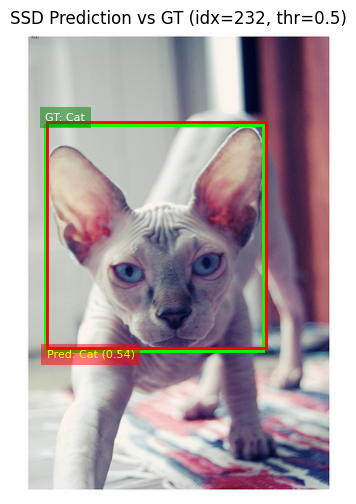

- idx=   4 | GT=Cat | Pred=Cat | IoU=0.958 | score=0.77 | status=success
  → 클래스/박스 둘 다 잘 맞음.


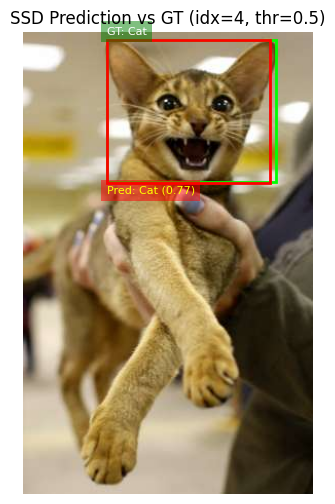


######## Success Cases - Dog ########
- idx= 702 | GT=Dog | Pred=Dog | IoU=0.976 | score=0.95 | status=success
  → 클래스/박스 둘 다 잘 맞음.


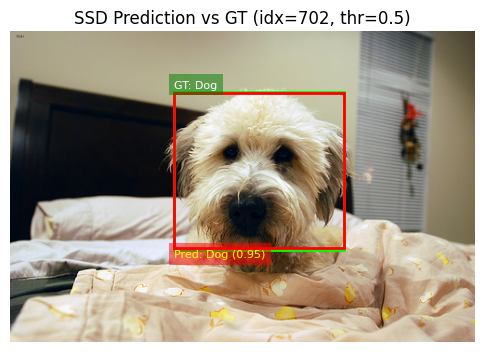

- idx= 571 | GT=Dog | Pred=Dog | IoU=0.966 | score=0.81 | status=success
  → 클래스/박스 둘 다 잘 맞음.


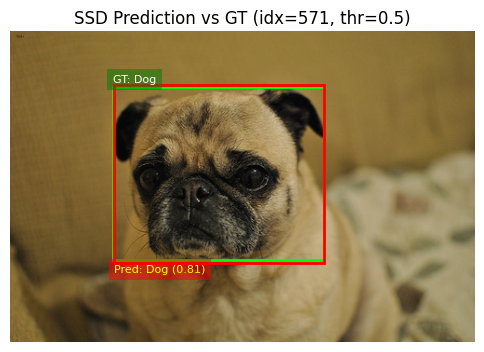


######## Failure Cases - Cat (wrong_class / low_iou) ########
- idx= 164 | GT=Cat | Pred=Dog | IoU=0.687 | score=0.52 | status=wrong_class
  → 종은 헷갈렸고, 박스는 얼굴/몸 쪽을 잡았는지 확인.


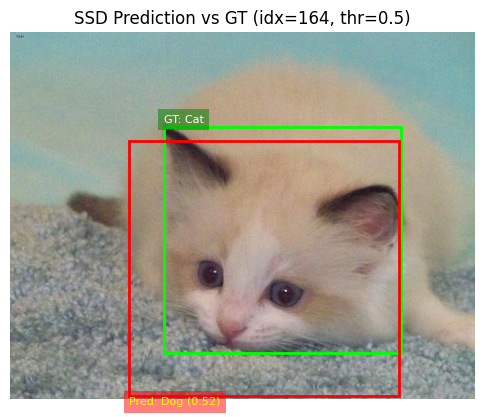

- idx=  55 | GT=Cat | Pred=Dog | IoU=0.709 | score=0.59 | status=wrong_class
  → 종은 헷갈렸고, 박스는 얼굴/몸 쪽을 잡았는지 확인.


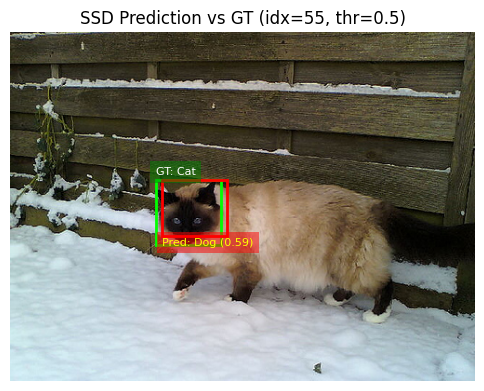


######## Failure Cases - Dog (wrong_class / low_iou) ########
- idx= 299 | GT=Dog | Pred=Cat | IoU=0.450 | score=0.52 | status=wrong_class
  → 종은 헷갈렸고, 박스는 얼굴/몸 쪽을 잡았는지 확인.


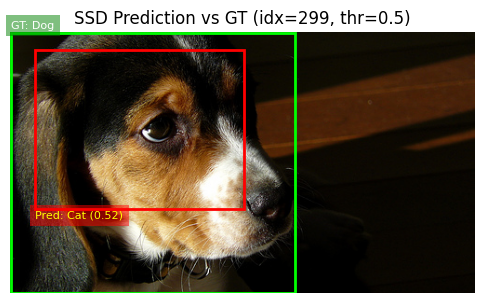

- idx= 665 | GT=Dog | Pred=Cat | IoU=0.619 | score=0.65 | status=wrong_class
  → 종은 헷갈렸고, 박스는 얼굴/몸 쪽을 잡았는지 확인.


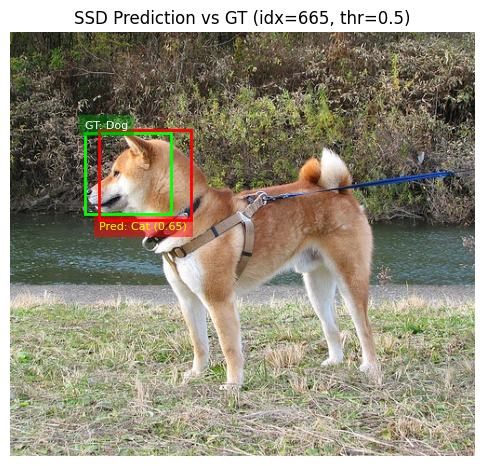

- idx= 399 | GT=Dog | Pred=Dog | IoU=0.032 | score=0.57 | status=low_iou
  → 종은 맞지만, 박스 위치/크기가 어긋난 케이스.


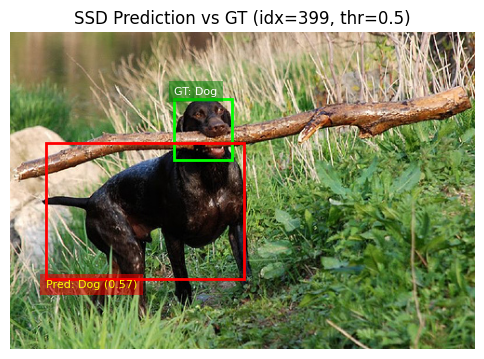

- idx= 345 | GT=Dog | Pred=Dog | IoU=0.226 | score=0.62 | status=low_iou
  → 종은 맞지만, 박스 위치/크기가 어긋난 케이스.


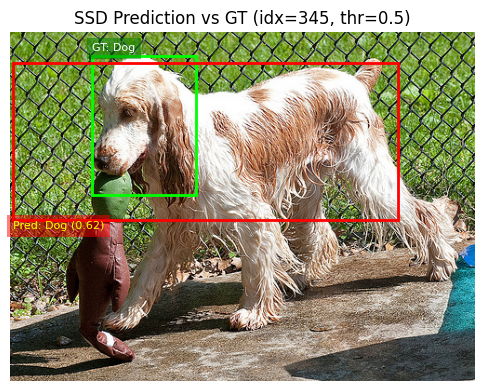


######## Failure Cases - No Detection ########
- idx= 469 | GT=Dog | Pred=None | IoU=0.000 | score=0.00 | status=no_detection
  → 아예 detection 실패. 배경/조명/포즈 영향 추정.


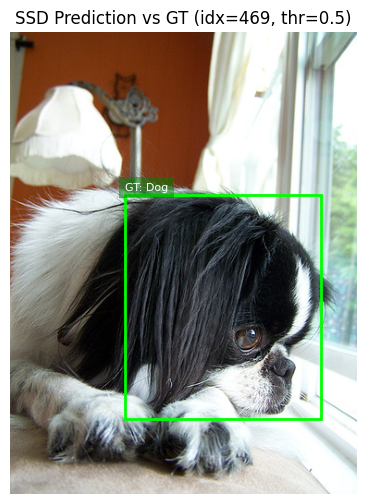

- idx= 122 | GT=Cat | Pred=None | IoU=0.000 | score=0.00 | status=no_detection
  → 아예 detection 실패. 배경/조명/포즈 영향 추정.


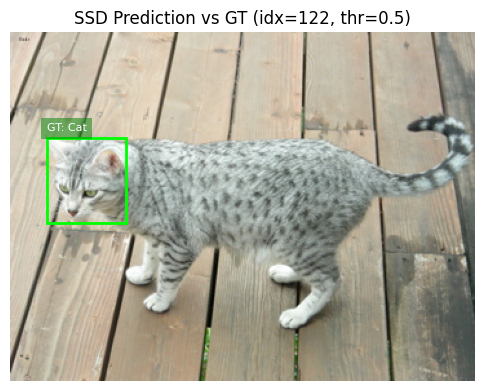

In [96]:
# ========== 시각화 ==========

show_cases_with_comments(
    val_dataset,
    model_ssd,
    device,
    good_cat,
    title="Success Cases - Cat",
    score_thresh=0.5,
)

show_cases_with_comments(
    val_dataset,
    model_ssd,
    device,
    good_dog,
    title="Success Cases - Dog",
    score_thresh=0.5,
)

show_cases_with_comments(
    val_dataset,
    model_ssd,
    device,
    fail_cat_wrong + fail_cat_low,
    title="Failure Cases - Cat (wrong_class / low_iou)",
    score_thresh=0.5,
)

show_cases_with_comments(
    val_dataset,
    model_ssd,
    device,
    fail_dog_wrong + fail_dog_low,
    title="Failure Cases - Dog (wrong_class / low_iou)",
    score_thresh=0.5,
)

show_cases_with_comments(
    val_dataset,
    model_ssd,
    device,
    no_det_cases,
    title="Failure Cases - No Detection",
    score_thresh=0.5,
)

# 회고

1. 전처리 과정에서 실제 파일 정보 - xml 어노테이션 파일 정보를 탐색하는 과정에서 혼선이 있었음. 파트를 처음부터 명확하게 쪼개서 eda 방향을 잡았어야 할듯

2. 비교용 모델 (aster R-CNN(ResNet50-FPN))  진행하려다가 안했음

3. EDA 결과 개선 미반영
*   EDA 결과 기반한 커스텀 트랜스폼을 진행했으나, 학습에 오히려 악영향 (파싱-실제 데이터 불일치 유발로 추정)



4. eda부터 결론까지 프로젝트가 똑바로 안 돌아감...아직도 맘에 안들고 정리하면서 버린 것도 많은데 지나치게 딜레이 돼서 더 할 수가 없다 (모델 성능, 개선방향 일관성, 전처리 개선 전부 불만족..)